# ETL-Project

In [37]:
# Import dependencies

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
import json
from pprint import pprint
import numpy as np

In [2]:
# Read the first csv - googleplaystore.csv and remove na

playstore_csv = "googleplaystore.csv"
playstore_df = pd.read_csv(playstore_csv)
playstore_df.dropna(inplace=True)

# Preview the DataFrame
playstore_df.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
# Find removing duplicates within the data only keep the last one

playstore_df = playstore_df.drop_duplicates(keep='last')


In [4]:
# Extract the Year from Last Updated column

playstore_df['Last Updated'] = pd.to_datetime(playstore_df['Last Updated'])
playstore_df['Last Updated - Year'] = playstore_df['Last Updated'].dt.year

# Preview the DataFrame
playstore_df.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Last Updated - Year
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,2018
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,2018
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2018


In [5]:
# Remove a few columns and export the clean version

playstore_clean = playstore_df.drop(columns=["Last Updated", "Current Ver", "Android Ver"])


In [6]:
# Filter the data only to Games & drop the category column

playstore_clean = playstore_clean.loc[playstore_clean["Category"] == 'GAME'] 

playstore_clean = playstore_clean.drop(columns=["Category"]).reset_index(drop=True)

# Preview the DataFrame
playstore_clean.head()


,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated - Year
0,ROBLOX,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,2018
1,Subway Surfers,4.5,27722264,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,2018
2,Candy Crush Saga,4.4,22426677,74M,"500,000,000+",Free,0,Everyone,Casual,2018
3,Solitaire,4.7,254258,23M,"10,000,000+",Free,0,Everyone,Card,2018
4,Bubble Shooter,4.5,148897,46M,"10,000,000+",Free,0,Everyone,Casual,2018


In [20]:
# Checking the last updated - Year

playstore_clean.groupby('Last Updated - Year').nunique()

,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated - Year
Last Updated - Year,,,,,,,,,,
2011,4,4,4,4,2,1,1,3,2,1
2012,2,2,2,2,2,1,1,1,2,1
2013,16,11,16,14,8,2,2,3,7,1
2014,26,11,26,23,9,2,4,4,8,1
2015,60,16,60,40,12,2,11,4,10,1
2016,73,18,73,52,13,2,8,4,9,1
2017,162,22,165,83,16,2,9,4,14,1
2018,571,22,711,120,18,2,9,4,24,1


### Data Visualisation

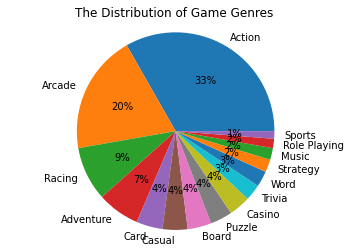

In [50]:
# Plot the top 15 game genres

playstore_clean['Genres'].value_counts().nlargest(15).plot(kind='pie', autopct='%.0f%%')
plt.axis("equal")

plt.title("The Distribution of Game Genres")
plt.ylabel("")

plt.show()


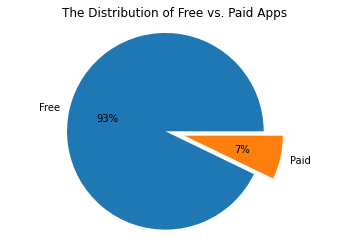

In [71]:
# Plot the distribution of Free & Paid apps

explode=[0.2,0]

playstore_clean['Type'].value_counts().plot(kind='pie', autopct='%.0f%%', explode=explode)

plt.axis("equal")

plt.title("The Distribution of Free vs. Paid Apps")
plt.ylabel("")

plt.show()
